In [1]:
import random
from matplotlib import pyplot as plt
import classification_data as cd
import numpy as np
from sklearn import metrics
from sklearn.svm import SVC
#from sklearn.svm import SVR

## Leitura da CNH

In [14]:
cnh_aberta =  cd.readpath('dataset/CNH_Aberta/*.jpg')
cnh_aberta =  cd.read_files(cnh_aberta)
cnh_aberta = cd.resize_img(cnh_aberta,(50,50))

cnh_frente =  cd.readpath('dataset/CNH_Aberta/*.jpg')
cnh_frente =  cd.read_files(cnh_frente)
cnh_frente = cd.resize_img(cnh_frente,(50,50))

cnh_verso =  cd.readpath('dataset/CNH_Aberta/*.jpg')
cnh_verso =  cd.read_files(cnh_verso)
cnh_verso = cd.resize_img(cnh_verso,(50,50))

## Leitura do CPF

In [3]:
cpf_frente =  cd.readpath('dataset/CNH_Aberta/*.jpg')
cpf_frente =  cd.read_files(cpf_frente)
cpf_frente = cd.resize_img(cpf_frente,(50,50))

cpf_verso =  cd.readpath('dataset/CNH_Aberta/*.jpg')
cpf_verso =  cd.read_files(cpf_verso)
cpf_verso = cd.resize_img(cpf_verso,(50,50))

## Leitura do RG

In [12]:
rg_frente =  cd.readpath('dataset/CNH_Aberta/*.jpg')
rg_frente =  cd.read_files(rg_frente)
rg_frente = cd.resize_img(rg_frente,(50,50))

rg_verso =  cd.readpath('dataset/CNH_Aberta/*.jpg')
rg_verso =  cd.read_files(rg_verso)
rg_verso = cd.resize_img(rg_verso,(50,50))

rg_aberto =  cd.readpath('dataset/CNH_Aberta/*.jpg')
rg_aberto =  cd.read_files(rg_aberto)
rg_aberto = cd.resize_img(rg_aberto,(50,50))

## Teste de plotagem

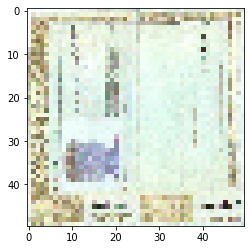

In [13]:
plt.imshow(rg_aberto[5])
plt.show()

## Preparando os dados para o treinamento

In [7]:
labels = [1,2,3,4,5,6,7,8]
documents = []

for a,b,c,d,e,f,g,h in zip(cnh_aberta,cnh_frente,cnh_verso,cpf_frente,cpf_verso,rg_frente,rg_verso,rg_aberto):
	documents.append({'x':a, 'y':labels[0]})
	documents.append({'x':b,'y':labels[1]})
	documents.append({'x':c,'y':labels[2]})
	documents.append({'x':d,'y':labels[3]})
	documents.append({'x':e,'y':labels[4]})
	documents.append({'x':f,'y':labels[5]})
	documents.append({'x':g,'y':labels[6]})
	documents.append({'x':h,'y':labels[7]})


In [8]:
x_train = []
y_train = []

x_test = []
y_test = []

i = 0
for document in documents:
	if i < 1000:
		x_train.append(document['x'])
		y_train.append(document['y'])
	else: break

i = 0
np.random.shuffle(documents[1000:]) #embaralhando os documentos
for document in documents[1000:]:
	if i < 1000:
		x_test.append(document['x'])
		y_test.append(document['y'])
	else: break


In [9]:
x_train, y_train = cd.started_values(x_train,y_train)
x_test, y_test = cd.started_values(x_test,y_test)

## Iniciando o treinamento usando o modelo SVC

In [10]:
document_classifier = SVC(kernel='linear')
document_classifier.fit(x_train,y_train)

test = random.choice(documents[1000:]) #escolhendo de forma aleatória

prediction  = document_classifier.predict(test['x'].reshape(1,-1))

## Resultados do treinamento

In [ ]:
print('Score:',document_classifier.score(x_train,y_train))
print('Document:', cd.result(prediction))

plt.imshow(test['x'])
plt.show()

# Acurácia

In [ ]:
print('Accuracy:',metrics.accuracy_score(y_test[:1000],y_train[:1000]))

# Regressão